#  MONAI Bootcamp
## Spleen Segmentation

<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>

In this notebook, we will implement Spleen segmentation using the Medical Decathalon dataset. We'll follow these general steps:

- Transforms for dictionary format data.
- Load Nifti image with metadata.
- Add channel dim to the data if no channel dimension.
- Scale medical image intensity with expected range.
- Crop out a batch of balanced images based on positive / negative label ratio.
- Cache IO and transforms to accelerate training and validation.
- 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
- Sliding window inference method.
- Deterministic training for reproducibility.
- Optionally replace the training loop with the Ignite-derived engine classes.

#### Required Packages 
This notebook has the pip command for installing MONAI and will be added to any subsequent notebook.
Execute the following cell to install MONAI the first time a colab notebook is run:

In [ ]:
#!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.8.1"

### Check GPU Support

Running `!nvidia-smi`

in a cell will verify this has worked and show you what kind of hardware you have access to.
if GPU Memory Usage is no `0 MiB` shutdown all kernels and restart current kernel.
- step1. shutdown kernel with following <b>Menu</b> > <b>Kernel</b> > <b>Shut Down All kernels </b>
- step2. restart kernelw with following <b>Menu</b> > <b>Kernel</b> > <b>Restart Kernel</b>


In [1]:
!nvidia-smi

Sat Nov  5 04:32:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:B7:00.0 Off |                   On |
| N/A   30C    P0    57W / 400W |     39MiB / 81920MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+

+-----------------------------------------------------------------------------+
| MIG d

### Setup imports

In [2]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

print_config()
set_determinism(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

MONAI version: 0.9.1
Numpy version: 1.22.0
Pytorch version: 1.11.0a0+bfe5ad2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 356d2d2f41b473f588899d705bbc682308cee52c
MONAI __file__: /opt/conda/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.10.0
gdown version: 4.5.1
TorchVision version: 0.12.0a0
tqdm version: 4.62.3
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.4.1
transformers version: 4.21.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## 1. Setting up our Dataset and exploring the data
#### Setup data directory

We'll create a temporary directory for all the MONAI data we're going to be using called temp directory in `~/monai-lab/temp`. 

In [3]:
import os 
import glob
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

temp


## download dataset 

it would take 1 minutes to download spleen dataset(1.5GB). You would also use cached dataset

You can check Medical Segmentation Decathlon dataset [homepage](http://medicaldecathlon.com/)

In [4]:
%%time 
import glob
import os

resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)
    

2022-11-05 04:33:23,078 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2022-11-05 04:33:23,082 - INFO - File exists: temp/Task09_Spleen.tar, skipped downloading.
2022-11-05 04:33:23,086 - INFO - Writing into directory: temp.
CPU times: user 6.14 s, sys: 3.09 s, total: 9.23 s
Wall time: 9.53 s


In [5]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

set_determinism(seed=0)

### visualize dataset
Let's use the nibabel library to visualize and examine the Spleen data in the form of a compressed file `nii.gz`.

In [ ]:
#!pip install SimpleITK   nibabel

In [6]:
val_files[0]

{'image': 'temp/Task09_Spleen/imagesTr/spleen_56.nii.gz',
 'label': 'temp/Task09_Spleen/labelsTr/spleen_56.nii.gz'}

In [7]:
def nii_loader(filename) :
    import nibabel as nib
    import numpy as np
    import matplotlib.pyplot as plt
    nimg = nib.load( filename )
    return nimg.get_fdata() , nimg.affine, nimg.header 

def visualize( dataset, idx=0, target_layer=10 ):
    import matplotlib.pyplot as plt    

    image = dataset[idx]['image']
    label = dataset[idx]['label']

    image_data, image_affine, image_header = nii_loader(image)
    label_data, label_affine,   label_header = nii_loader(label)

    print(image_data.shape, label_data.shape )
    target_image = image_data[:,:,target_layer]
    target_label = label_data[:,:,target_layer]

    fig, (ax1, ax2) = plt.subplots(1, 2 ,  figsize=(12,8))

    ax1.imshow(target_image, cmap='gray' )
    ax1.set_title('image')
    ax2.imshow(target_label )
    ax2.set_title('GT segmentation')
    plt.show()


(512, 512, 41) (512, 512, 41)


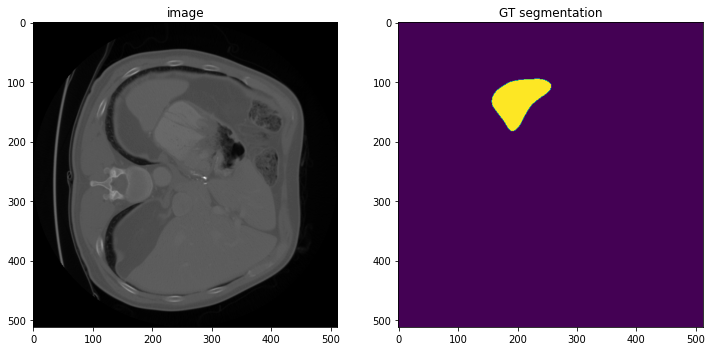

In [8]:
visualize( val_files, idx=8,  target_layer=30 ) # check different idx

## MONAI Dataloader
### transforms 

In [ ]:
from monai.transforms import Compose

train_transforms = Compose(
    [
        #???
    ]
)

val_transforms = Compose(
    [
        #???
    ]
)

## transform for CT dataset
 - random crop

In [9]:
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)

In [10]:
from monai.transforms import Compose

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

image shape: (226, 157, 113), label shape: (226, 157, 113)


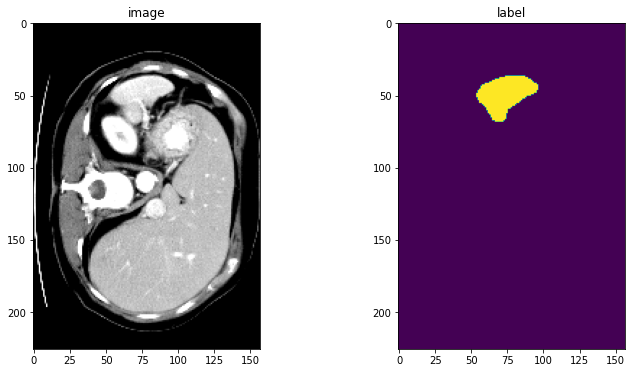

In [11]:
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.utils import first, set_determinism

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

### MONAI data cache

<b>class monai.data.CacheDataset</b>(`data, transform, cache_num=9223372036854775807, cache_rate=1.0, num_workers=None, progress=True, copy_cache=True, as_contiguous=True, hash_as_key=False, hash_func=<function pickle_hashing>`)

Dataset with cache mechanism that can load data and cache deterministic transforms’ result during training.

By caching the results of non-random preprocessing transforms, it accelerates the training data pipeline. 
Users can set the cache rate or number of items to cache. It is recommended to experiment with different cache_num or cache_rate to identify the best training speed.




It takes 2 minutes to load dataset.

In [12]:
%%time 
from monai.data import CacheDataset, DataLoader

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4, progress=True)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=10)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4, progress=True)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=10)

Loading dataset: 100%|██████████| 9/9 [00:33<00:00,  3.73s/it]

CPU times: user 9min 46s, sys: 2min 52s, total: 12min 38s
Wall time: 3min 25s


### Monai Network
MONAI provides predefined networks. we can easily import it. 

- [Layers](https://docs.monai.io/en/stable/networks.html#layers) : Act, Conv, Norm, Dropout, Flatten, Reshape, Pad, Pool, SkipConnection
- [Blocks](https://docs.monai.io/en/stable/networks.html#module-monai.networks.blocks) : ADN, Convolution, Synamic UnetBlock, FCN, GCN, Squeeze-andExcitation, ResNeXt, SABlock, Transformer Block, 
- [Nets](https://docs.monai.io/en/stable/networks.html#nets)  : DenseNet121, EfficientNet, SegResNet, ResNet, SENet154, DyUNet, UNet, AutoEncoder, VarAutoEncoder, ViT, 

### UNet

[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
U Shaped Network was developed by Olaf Ronneberger et al. for Bio Medical Image Segmentation. 
It is Fully Convolutional Network Model for the segmentation task with two paths(encoder and decoder) with 1x1 convolution skip connection similar as residual. 
<img src="https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png" width=800>

#### UNet in monai.networks
class monai.networks.nets.<b>UNet </b> (`spatial_dims, in_channels, out_channels, channels, strides, kernel_size=3, up_kernel_size=3, num_res_units=0, act='PRELU', norm='INSTANCE', dropout=0.0, bias=True, dimensions=None` )
Enhanced version of <br>UNet</b> which has residual units implemented with the `ResidualUnit` class. The residual part uses a convolution to change the input dimensions to match the output dimensions if this is necessary but will use `nn.Identity` if not. Refer to: [Link](https://link.springer.com/chapter/10.1007/978-3-030-12029-0_40).

Each layer of the network has a encode and decode path with a skip connection between them. Data in the encode path is downsampled using strided convolutions (if strides is given values greater than 1) and in the decode path upsampled using strided transpose convolutions. These down or up sampling operations occur at the beginning of each block rather than afterwards as is typical in <b>UNet</b> implementations.

To further explain this consider the first example network given below. This network has 3 layers with strides of 2 for each of the middle layers (the last layer is the bottom connection which does not down/up sample). Input data to this network is immediately reduced in the spatial dimensions by a factor of 2 by the first convolution of the residual unit defining the first layer of the encode part. The last layer of the decode part will upsample its input (data from the previous layer concatenated with data from the skip connection) in the first convolution. this ensures the final output of the network has the same shape as the input.

Padding values for the convolutions are chosen to ensure output sizes are even divisors/multiples of the input sizes if the strides value for a layer is a factor of the input sizes. A typical case is to use strides values of 2 and inputs that are multiples of powers of 2. An input can thus be downsampled evenly however many times its dimensions can be divided by 2, so for the example network inputs would have to have dimensions that are multiples of 4. In the second example network given below the input to the bottom layer will have shape `(1, 64, 15, 15)` for an input of shape `(1, 1, 240, 240)` demonstrating the input being reduced in size spatially by 2**4.

##### Parameters
 - <b>spatial_dims </b>(`int`)  – number of spatial dimensions.
 - <b>in_channels </b>(`int`) – number of input channels.
 - <b>out_channels </b>(`int`) – number of output channels.
 - <b>channels</b> (`Sequence[int]`) – sequence of channels. Top block first. The length of channels should be no less than 2.
 - <b>strides</b> (`Sequence[int]`) – sequence of convolution strides. The length of stride should equal to len(channels) - 1.
 - <b>kernel_size</b> (`Union[Sequence[int], int]`) – convolution kernel size, the value(s) should be odd. If sequence, its length should equal to dimensions. Defaults to 3.
 - <b>up_kernel_size</b> (`Union[Sequence[int], int]`) – upsampling convolution kernel size, the value(s) should be odd. If sequence, its length should equal to dimensions. Defaults to 3.
 - <b>num_res_units</b>  (`int`)– number of residual units. Defaults to 0.
 - <b>act</b> (`Union[Tuple, str]`) – activation type and arguments. Defaults to PReLU.
 - <b>norm</b> (`Union[Tuple, str]`) – feature normalization type and arguments. Defaults to instance norm.
 - <b>dropout</b> (`float`) – dropout ratio. Defaults to no dropout.
 - <b>bias (`bool`)</b> – whether to have a bias term in convolution blocks. Defaults to True. According to Performance Tuning Guide, if a conv layer is directly followed by a batch norm layer, bias should be False.

In [13]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm


device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)


### Dice Loss 


<img src="https://cdn-images-1.medium.com/max/1600/0*HuENmnLgplFLg7Xv" width=400>
 
 #### Dice Loss in MONAI losses
 
 class monai.losses.<b>DiceLoss</b>(`include_background=True, to_onehot_y=False, sigmoid=False, softmax=False, other_act=None, squared_pred=False, jaccard=False, reduction=LossReduction.MEAN, smooth_nr=1e-05, smooth_dr=1e-05, batch=False`)
 Compute average Dice loss between two tensors. It can support both multi-classes and multi-labels tasks. The data input (`BNHW[D]` where N is number of classes) is compared with ground truth target (`BNHW[D]`).

Note that axis N of input is expected to be logits or probabilities for each class, if passing logits as input, must set `sigmoid=True` or `softmax=True`, or specifying `other_act`. And the same axis of target can be 1 or N (one-hot format).

The smooth_nr and smooth_dr parameters are values added to the intersection and union components of the inter-over-union calculation to smooth results respectively, these values should be small.

The original paper: Milletari, F. et. al. (2016) V-Net: Fully Convolutional Neural Networks forVolumetric Medical Image Segmentation, 3DV, 2016.


In [14]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [15]:
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [16]:
from monai.data.utils import decollate_batch
from monai.transforms import EnsureType, AsDiscrete
from monai.inferers import sliding_window_inference

max_epochs = 50
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])


In [17]:
%%time 

import time 

for epoch in range(max_epochs):
    tic_epoch = time.time()
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 5 ==0:
            print(
                f"\nepoch {epoch + 1}/{max_epochs}"
                f" steps {step}/{len(train_ds) // train_loader.batch_size}, "
                f"|train_loss: {loss.item():.4f}", end='')
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    toc_epoch = time.time()
    dur_epoch = toc_epoch - tic_epoch
    print(f" |avg loss: {epoch_loss:.4f} dur {dur_epoch:.1f}s ", end='')

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            #print( "| Val Dice metric {:6.4f}".format(metric) , end='')
            # reset the status for next validation round
            dice_metric.reset()

            
            metric_values.append(metric)
            print(
                f"|DICE cur: {metric:.4f}"
                f" old best : {best_metric:.4f} "
                f"at {best_metric_epoch}" , end=''            )
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "spleen_unet_model_best.pth"))
                
                print("|best model saved", end='')            

    if (epoch+1) % 10 == 0: 
        torch.save(model.state_dict(), os.path.join(root_dir, "spleen_unet_model_{:04d}.pth".format(epoch+1)))
        torch.save(optimizer.state_dict(), os.path.join(root_dir, "spleen_unet_optim_{:04d}.pth".format(epoch+1)))
        print("|{}ep model saved".format(epoch+1), end='')
                            
print(
    f"\ntrain completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}"
    f" for {max_epochs} epoches" )


epoch 1/50 steps 5/16, |train_loss: 0.6555
epoch 1/50 steps 10/16, |train_loss: 0.6701
epoch 1/50 steps 15/16, |train_loss: 0.6577 |avg loss: 0.6582 dur 19.8s 
epoch 2/50 steps 5/16, |train_loss: 0.6304
epoch 2/50 steps 10/16, |train_loss: 0.6316
epoch 2/50 steps 15/16, |train_loss: 0.5930 |avg loss: 0.6266 dur 16.1s |DICE cur: 0.0403 old best : -1.0000 at -1|best model saved
epoch 3/50 steps 5/16, |train_loss: 0.6146
epoch 3/50 steps 10/16, |train_loss: 0.6151
epoch 3/50 steps 15/16, |train_loss: 0.6117 |avg loss: 0.6095 dur 15.9s 
epoch 4/50 steps 5/16, |train_loss: 0.6178
epoch 4/50 steps 10/16, |train_loss: 0.5895
epoch 4/50 steps 15/16, |train_loss: 0.5883 |avg loss: 0.5874 dur 16.5s |DICE cur: 0.0747 old best : 0.0403 at 2|best model saved
epoch 5/50 steps 5/16, |train_loss: 0.5831
epoch 5/50 steps 10/16, |train_loss: 0.5781
epoch 5/50 steps 15/16, |train_loss: 0.5606 |avg loss: 0.5796 dur 17.3s 
epoch 6/50 steps 5/16, |train_loss: 0.5562
epoch 6/50 steps 10/16, |train_loss: 0.5

### check loss and metric

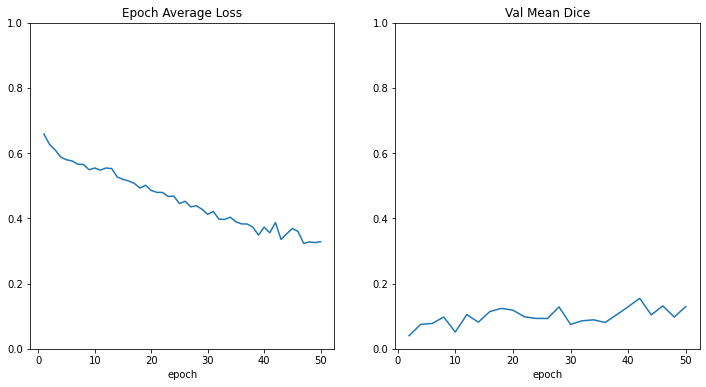

In [18]:
import matplotlib.pyplot as plt

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.ylim(0,1)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.ylim(0,1)
plt.show()

In [19]:
def inference_segment(model, roi_size, sw_batch_size, num_data=2):
    with torch.no_grad():
        for i, val_data in enumerate(val_loader):
            roi_size = (160, 160, 160)
            sw_batch_size = 4
            val_outputs = sliding_window_inference(
                val_data["image"].to(device), roi_size, sw_batch_size, model
            )
            # plot the slice [:, :, 80]
            plt.figure("check", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image {i}")
            plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label {i}")
            plt.imshow(val_data["label"][0, 0, :, :, 80])
            plt.subplot(1, 3, 3)
            plt.title(f"output {i}")
            plt.imshow(torch.argmax(
                val_outputs, dim=1).detach().cpu()[0, :, :, 80])
            plt.show()
            if i == num_data:
                break                
    
def inference_segment_best(work_dir, model, prefix, roi_size, sw_batch_size, num_data=2):
    import torch
    model.load_state_dict(torch.load(os.path.join(work_dir, "spleen_{}_model_best.pth".format(prefix) )))
    model.eval()
    inference_segment(model, roi_size, sw_batch_size, num_data)

def inference_segment_epoch(work_dir, model, prefix, roi_size, sw_batch_size, epoch=30, num_data=2):
    import torch
    model.load_state_dict(torch.load(os.path.join(work_dir, "spleen_{}_model_{:04d}.pth".format(prefix, epoch))))
    model.eval()
    inference_segment(model, roi_size, sw_batch_size, num_data)

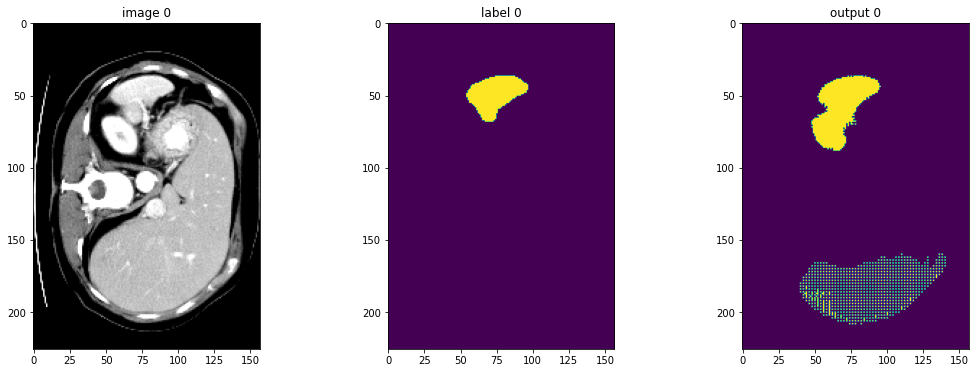

In [23]:
inference_segment_best(root_dir, model,  'unet', roi_size, sw_batch_size, num_data=0)

## resume with pretrained checkpoint
we could resume train. 
For inference, we needs only model parameters. However, we need not only model parameters but also optimizer parameters for resume train. for AMP(automatic mixed precision), we also need scaler. 
In `root_dir`, the model parameter is saved as `spleen_model_0050.pth` file name and the optim parameter is saved as `spleen_optim_0050.pth` file name. Both files are required to resume learning.




In [24]:
!ls -alh temp/spleen*.pth

-rw-rw-r-- 1 f3mx6wqa f3mx6wqa 19M Nov  5 04:50 temp/spleen_unet_model_0010.pth
-rw-rw-r-- 1 f3mx6wqa f3mx6wqa 19M Nov  5 04:54 temp/spleen_unet_model_0020.pth
-rw-rw-r-- 1 f3mx6wqa f3mx6wqa 19M Nov  5 04:57 temp/spleen_unet_model_0030.pth
-rw-rw-r-- 1 f3mx6wqa f3mx6wqa 19M Nov  5 05:01 temp/spleen_unet_model_0040.pth
-rw-rw-r-- 1 f3mx6wqa f3mx6wqa 19M Nov  5 05:05 temp/spleen_unet_model_0050.pth
-rw-rw-r-- 1 f3mx6wqa f3mx6wqa 19M Nov  5 05:02 temp/spleen_unet_model_best.pth
-rw-rw-r-- 1 f3mx6wqa f3mx6wqa 37M Nov  5 04:50 temp/spleen_unet_optim_0010.pth
-rw-rw-r-- 1 f3mx6wqa f3mx6wqa 37M Nov  5 04:54 temp/spleen_unet_optim_0020.pth
-rw-rw-r-- 1 f3mx6wqa f3mx6wqa 37M Nov  5 04:57 temp/spleen_unet_optim_0030.pth
-rw-rw-r-- 1 f3mx6wqa f3mx6wqa 37M Nov  5 05:01 temp/spleen_unet_optim_0040.pth
-rw-rw-r-- 1 f3mx6wqa f3mx6wqa 37M Nov  5 05:05 temp/spleen_unet_optim_0050.pth


In [25]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm


device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)


In [26]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
loss_function = DiceLoss(to_onehot_y=True, softmax=True)

dice_metric = DiceMetric(include_background=False, reduction="mean")

In [27]:
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In order to examine both the Dice metric and the projectory of loss during initial learning and re-execution of learning, `best_metric`, `best_metric_epoch`, `epoch_loss_values` and `metric_values` were annotated to utilize the variables stored in the previous learning. All of these variables are necessary for re-learning after resetting the kernel.

In [28]:
from monai.data.utils import decollate_batch
from monai.transforms import EnsureType, AsDiscrete
from monai.inferers import sliding_window_inference

max_epochs = 100 ## 
resume_epoch = 1
val_interval = 2
#best_metric = -1
#best_metric_epoch = -1
#epoch_loss_values = []
#metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])

In [29]:

prefix = 'unet'
model.load_state_dict(    torch.load(os.path.join(root_dir, "spleen_{}_model_{:04d}.pth".format(prefix, resume_epoch))))
optimizer.load_state_dict(torch.load(os.path.join(root_dir, "spleen_{}_optim_{:04d}.pth".format(prefix, resume_epoch))))

FileNotFoundError: [Errno 2] No such file or directory: 'temp/spleen_unet_model_0001.pth'

In [30]:
%%time 
import time 
print("resume to train")
for epoch in range(resume_epoch, max_epochs):

    tic_epoch = time.time()
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 5 ==0:
            print(
                f"\nepoch {epoch + 1}/{max_epochs}"
                f" steps {step}/{len(train_ds) // train_loader.batch_size}, "
                f"|train_loss: {loss.item():.4f}", end='')
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    toc_epoch = time.time()
    dur_epoch = toc_epoch - tic_epoch
    print(f" |avg loss: {epoch_loss:.4f} dur {dur_epoch:.1f}s ", end='')

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            #print( "| Val Dice metric {:6.4f}".format(metric) , end='')
            # reset the status for next validation round
            dice_metric.reset()

            
            metric_values.append(metric)
            print(
                f"|DICE cur: {metric:.4f}"
                f" old best : {best_metric:.4f} "
                f"at {best_metric_epoch}" , end=''            )
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "spleen_unet_model_best.pth"))
                
                print("|best model saved", end='')            

    if (epoch+1) % 10 == 0: 
        torch.save(model.state_dict(), os.path.join(root_dir, "spleen_unet_model_{:04d}.pth".format(epoch+1)))
        torch.save(optimizer.state_dict(), os.path.join(root_dir, "spleen_unet_optim_{:04d}.pth".format(epoch+1)))
        print("|{}ep model saved".format(epoch+1), end='')
                            
print(
    f"\ntrain completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}"
    f" for {max_epochs} epoches" )    

resume to train

epoch 2/100 steps 5/16, |train_loss: 0.6131
epoch 2/100 steps 10/16, |train_loss: 0.6015
epoch 2/100 steps 15/16, |train_loss: 0.5904 |avg loss: 0.6052 dur 17.1s |DICE cur: 0.0545 old best : 0.1548 at 42
epoch 3/100 steps 5/16, |train_loss: 0.5847
epoch 3/100 steps 10/16, |train_loss: 0.5633
epoch 3/100 steps 15/16, |train_loss: 0.5693 |avg loss: 0.5823 dur 16.8s 

KeyboardInterrupt: 

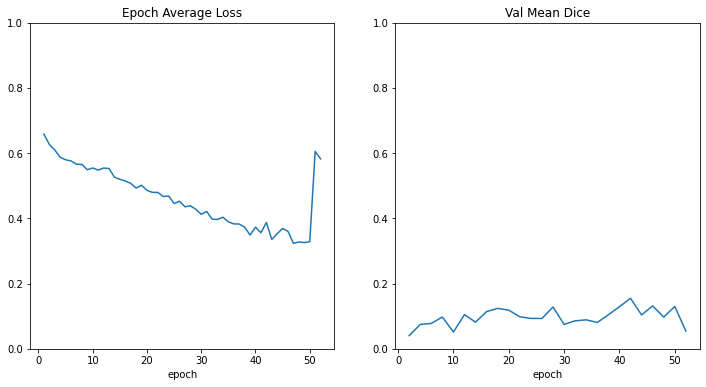

In [31]:
import matplotlib.pyplot as plt

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.ylim(0,1)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.ylim(0,1)
plt.show()

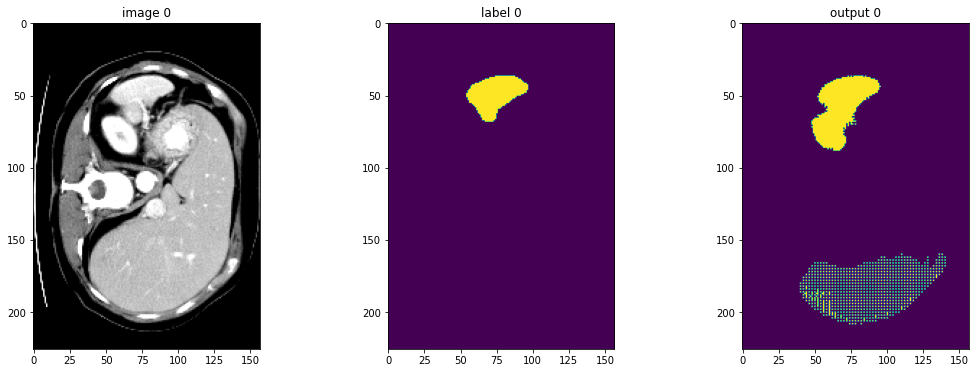

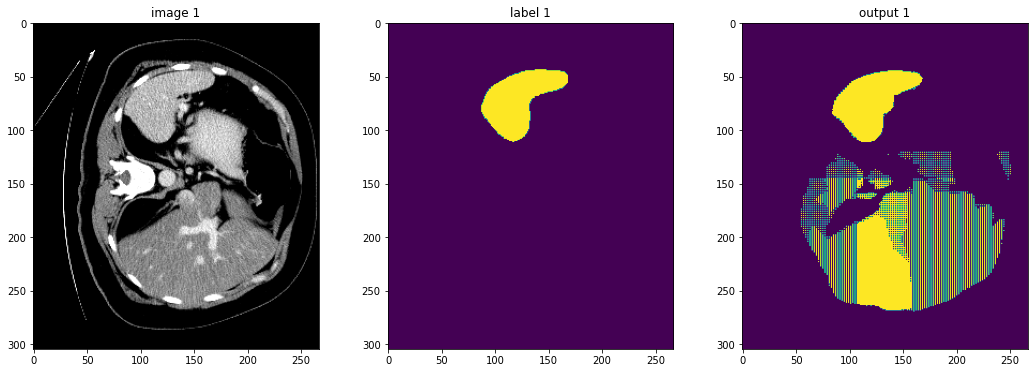

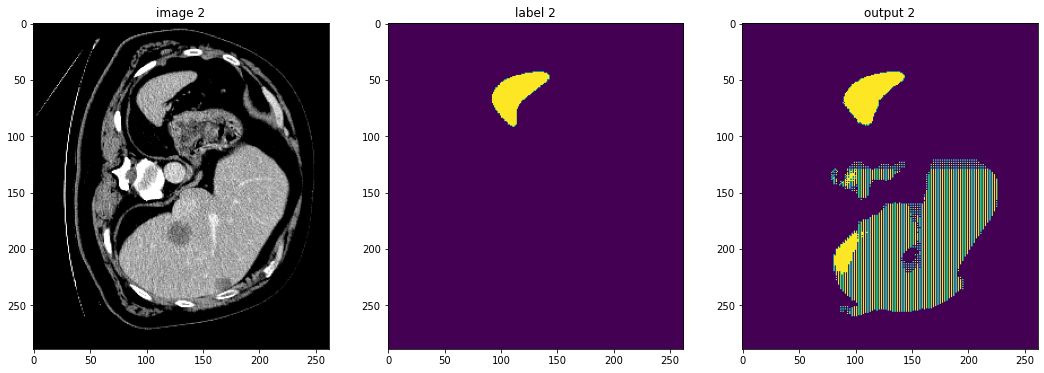

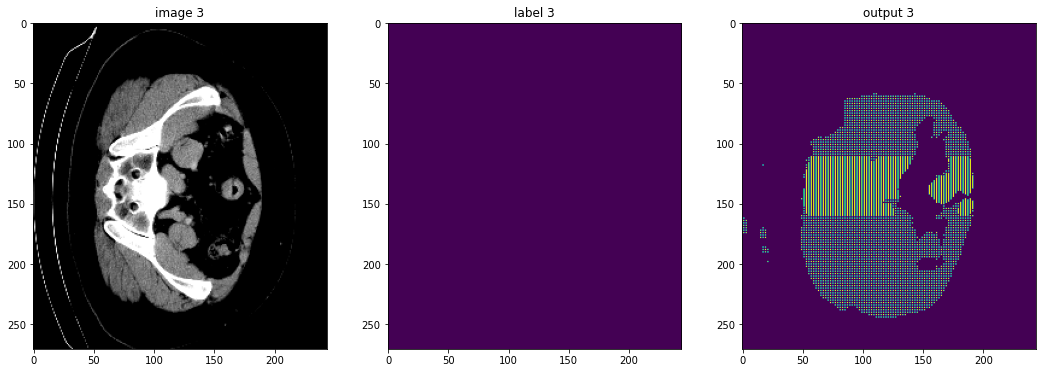

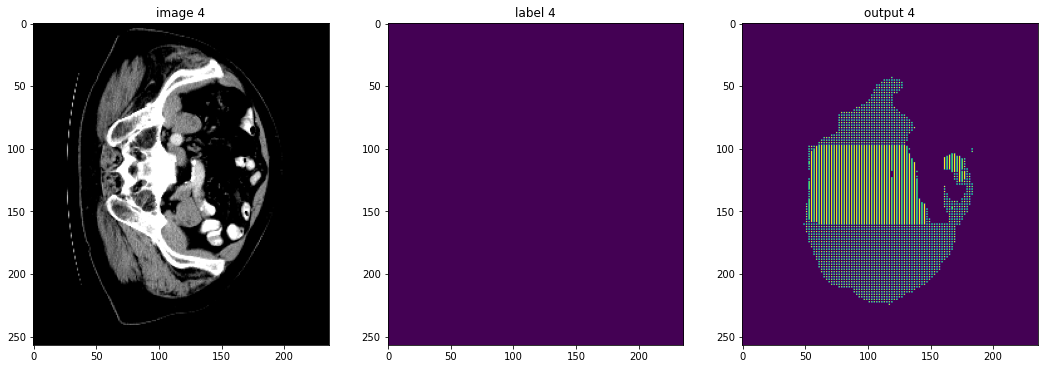

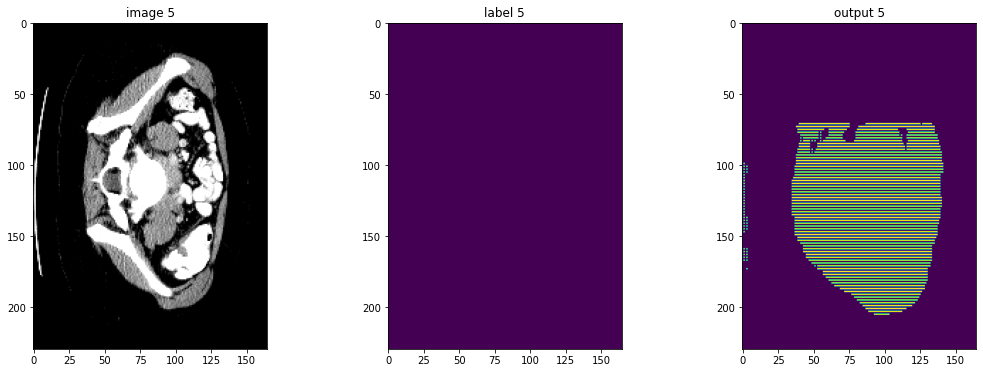

In [35]:
inference_segment_best(root_dir, model, 'unet', roi_size, sw_batch_size, num_data=5)

### evaluate for each 10 epochs

In [ ]:
!ls -alh temp/spleen*.pth

In [ ]:
inference_segment_epoch(root_dir, model, 'unet', roi_size, sw_batch_size, epoch=10, num_data=0)
inference_segment_epoch(root_dir, model, 'unet', roi_size, sw_batch_size, epoch=20, num_data=0)
inference_segment_epoch(root_dir, model, 'unet', roi_size, sw_batch_size, epoch=30, num_data=0)
inference_segment_epoch(root_dir, model, 'unet', roi_size, sw_batch_size, epoch=40, num_data=0)
inference_segment_epoch(root_dir, model, 'unet', roi_size, sw_batch_size, epoch=50, num_data=0)
inference_segment_epoch(root_dir, model, 'unet', roi_size, sw_batch_size, epoch=60, num_data=0)
inference_segment_epoch(root_dir, model, 'unet', roi_size, sw_batch_size, epoch=70, num_data=0)
inference_segment_epoch(root_dir, model, 'unet', roi_size, sw_batch_size, epoch=80, num_data=0)
inference_segment_epoch(root_dir, model, 'unet', roi_size, sw_batch_size, epoch=90, num_data=0)
inference_segment_epoch(root_dir, model, 'unet', roi_size, sw_batch_size, epoch=100, num_data=0)

In this notebook, we conducted the split segmentation task using UNet model in CT data using MONAI network class. Additionally, we looked at the resume method of learning.

## inference with saved checkpoint

In today's workshop, we only learned 10 epochs due to time constraints. It provides learning parameters that proceeded 700 epoch learning for model verification. The parameter file is stored in a folder named `saved`. 700 epoch The file name of the learned parameter is `spleen_model_0700.pth`.
In 700 epoch learning, the parameter with the best DICE metric is saved in the file: `spleen_model_best.pth`.


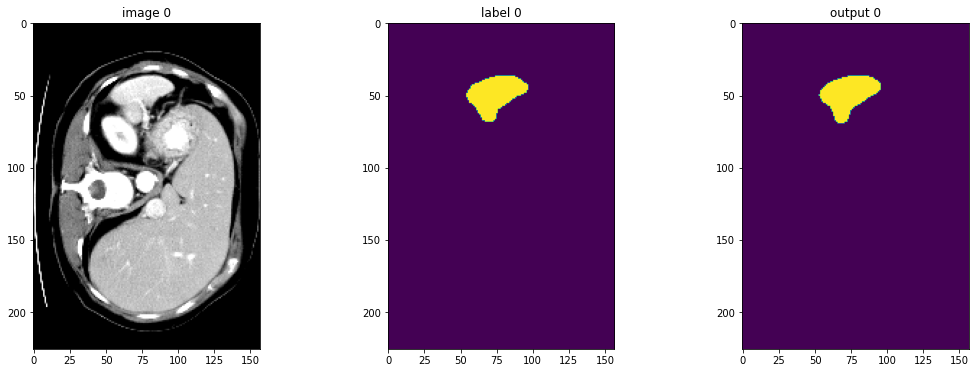

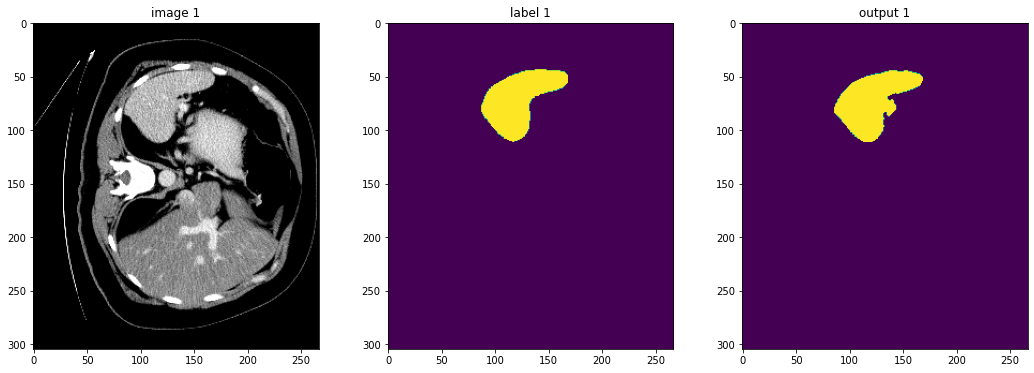

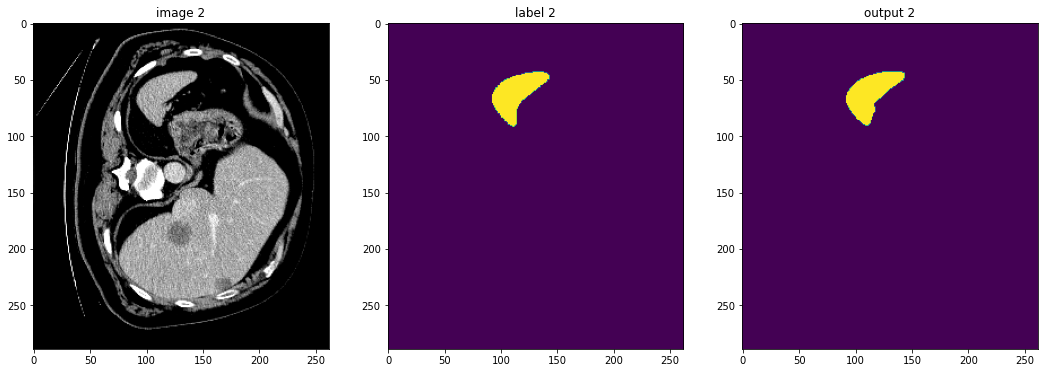

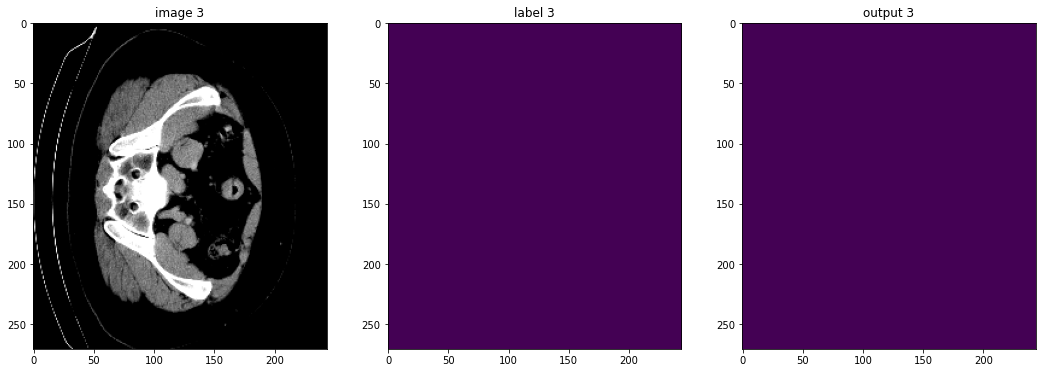

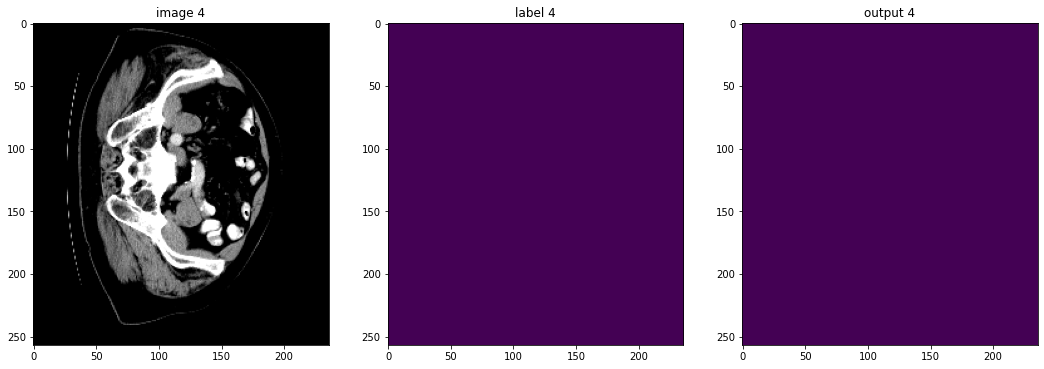

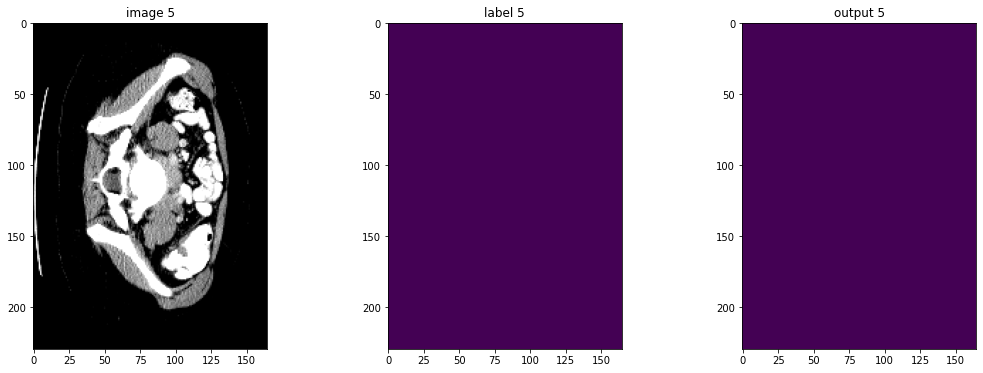

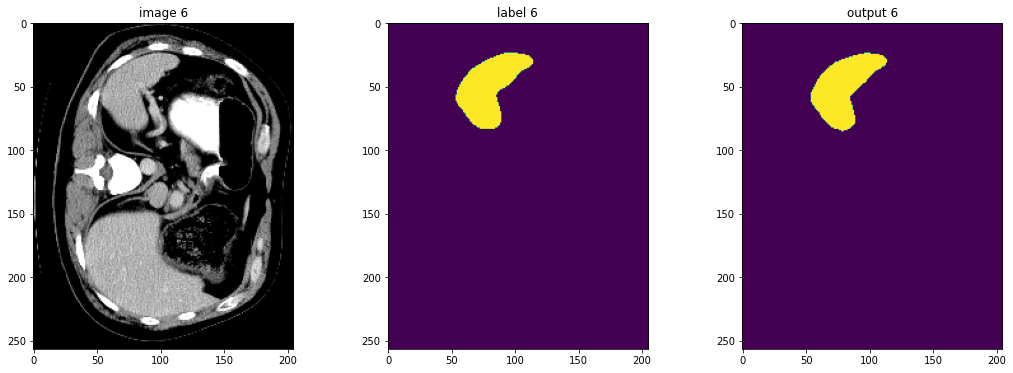

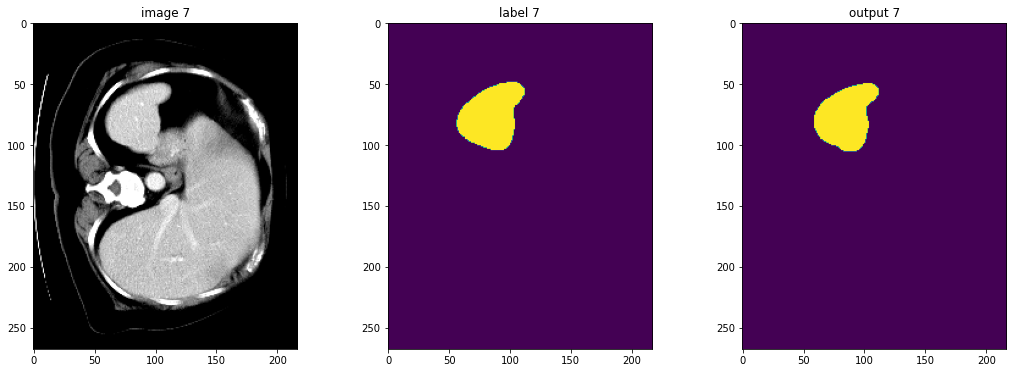

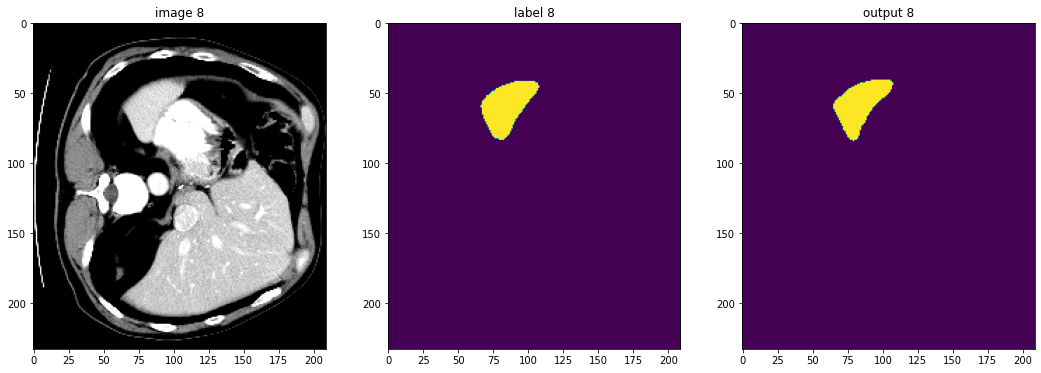

In [36]:
inference_segment_epoch('saved', model, 'unet', roi_size, sw_batch_size, epoch=700, num_data=10)

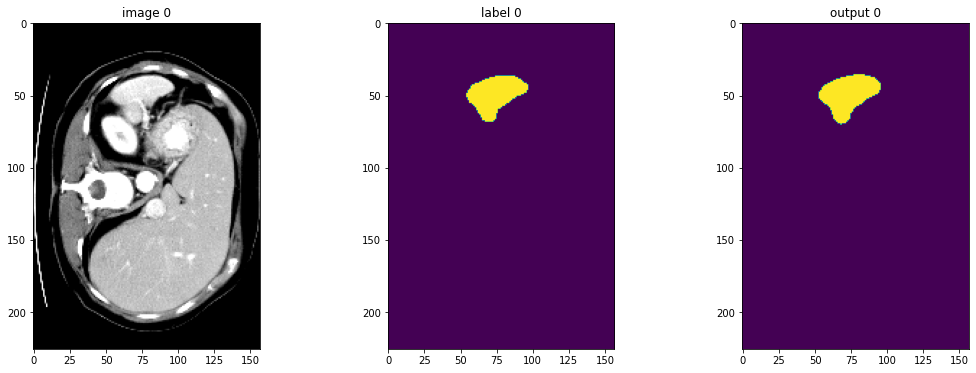

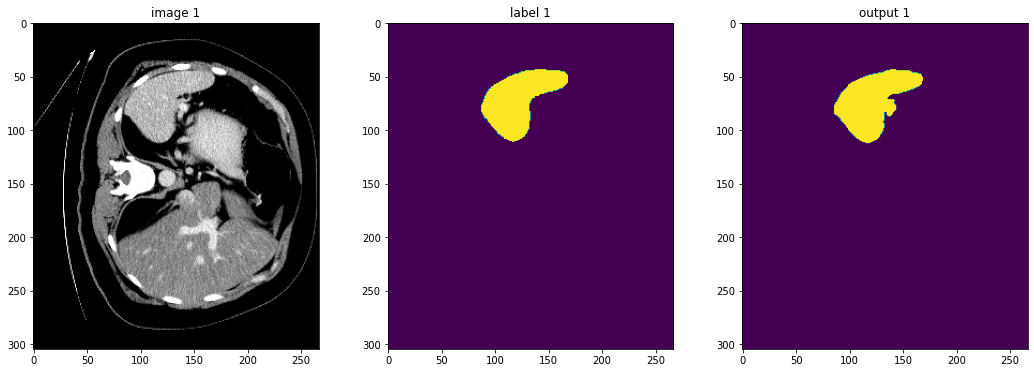

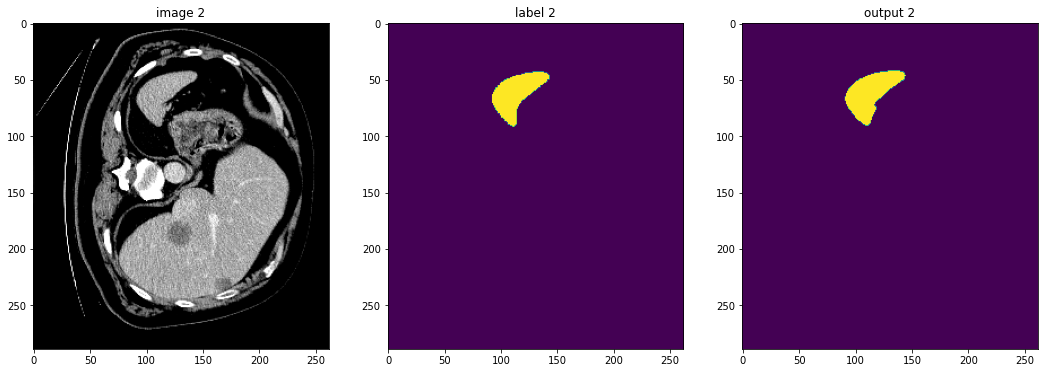

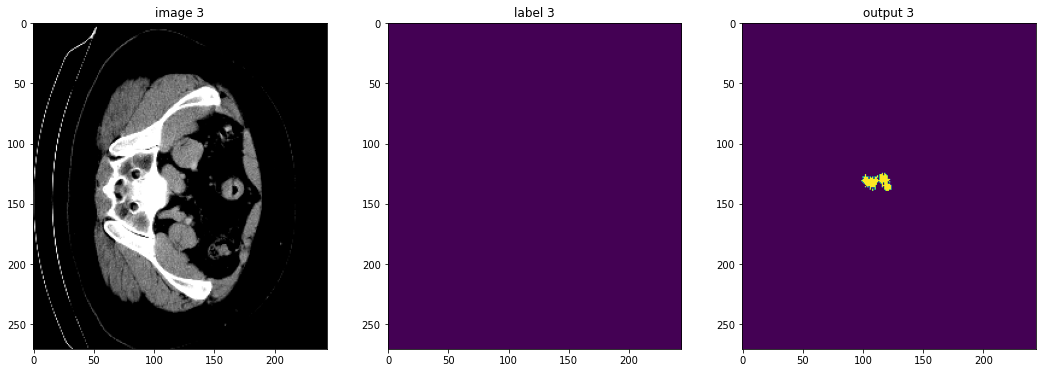

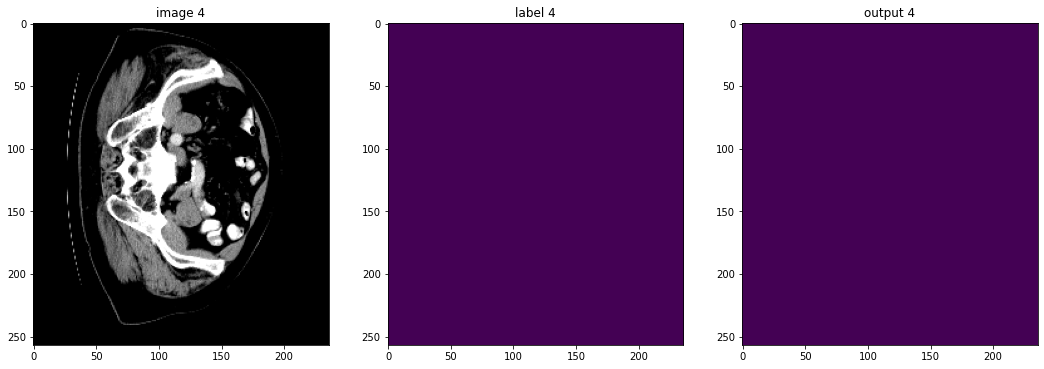

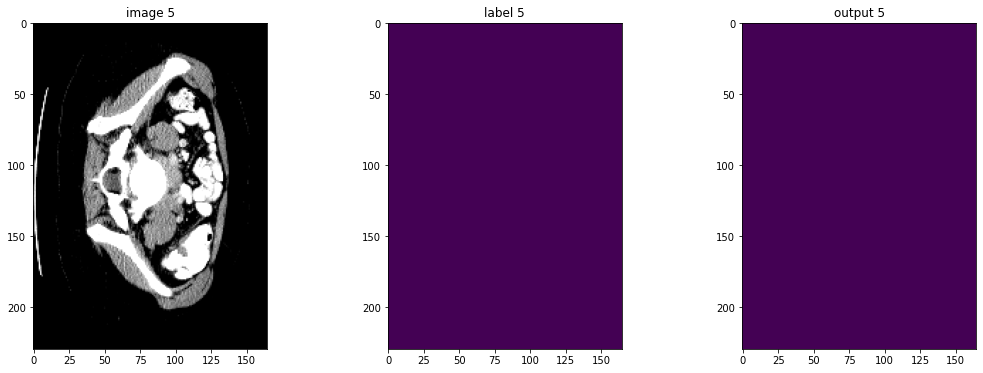

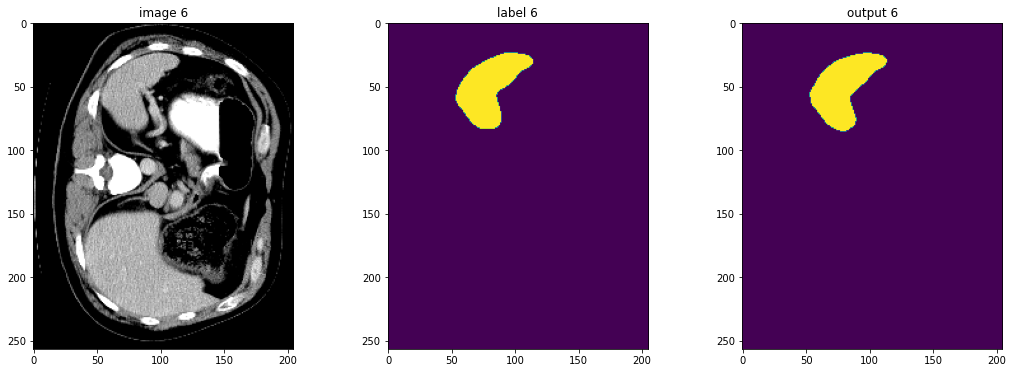

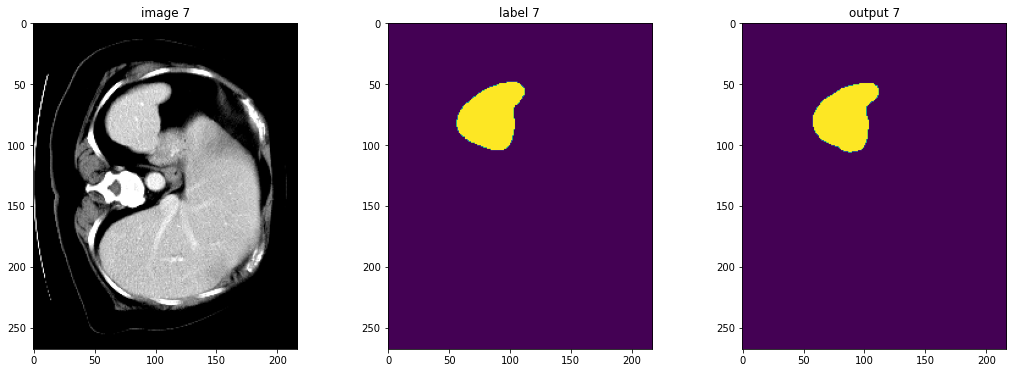

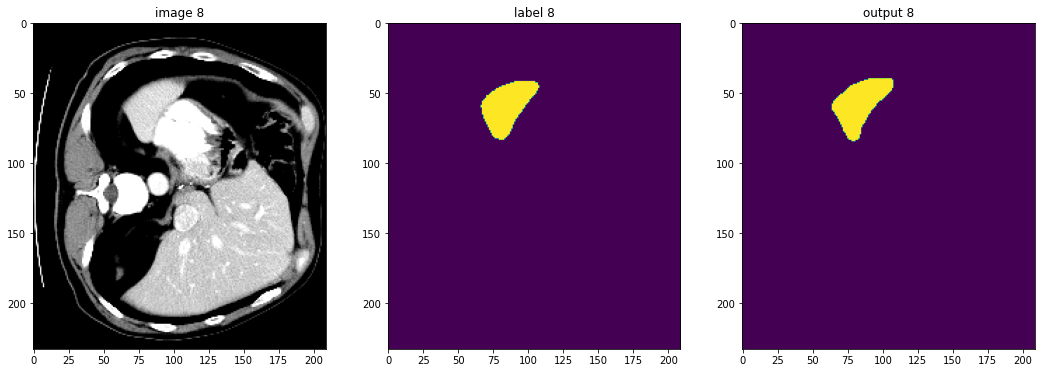

In [42]:
inference_segment_best('saved', model, 'unet', roi_size, sw_batch_size, num_data=10)

## Caution !!!
### please shutdown all kernels with [Kernel] menu >  [Shutdown All Kernel]  before launch next notebook

## Navigation
- [01_getting started](./01_getting.ipynb)

- [02_pipeline_01](./02_pipeline_01.ipynb)
- [02_pipeline_02 ](./02_pipeline_02.ipynb)
- [02_pipeline_03](./02_pipeline_03.ipynb)
- [02_pipeline_04  ](./02_pipeline_04.ipynb)

- [03_brain_gan ](./03_brain_gan_01.ipynb)

- [04_spleen_segment ](./04_spleen_segment.ipynb) 

- [05_challenge_cardiac baseline Next ](./05_challenge_cardiac_baseline.ipynb) 

- [05_challenge_cardiac workspace](./05_challenge_cardiac_workspace.ipynb) 

<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>